In [337]:
# Task: National rent growth forecast: Provide your forecasted annual U.S. rent growth 
# figures (year-over-year as of Q4) for 2025, 2026, 2027, and 2028. 
# Discuss the result – does (or does not) the model make intuitive sense based 
# on the trend presented by the data and your understanding of the macro-economy and real estate market?


# Import basic packages for exploratory data analysis
# More packages are added as need and are written in the particular cells which use them

# Please uncomment below to install any packages you may not have in your Jupyter Notebook Set up
#!pip install pandas numpy scikit-learn statsmodels matplotlib seaborn linearmodels matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [338]:
#Import data (The data is in my Lasalle_Assessment Folder ... please check your path)

hist_rent_data = pd.read_excel('Ind Fund Data.xlsx')
hist_rent_data.head()

,yyyy.q,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,metro_mkt,emp_mkt,emp.const_mkt,emp.manf_mkt,ret_us,emp_us,emp.const_us,emp.manf_us
0,2004.4,Allentown,78202.0,538.0,1710.0,0.140,5.300719,67253.720,"Allentown-Bethlehem-Easton, PA-NJ",331.4355,15.5822,42.0616,83.085,132525.7,7095.016,14308.70
1,2005.1,Allentown,79282.0,1080.0,1664.0,0.131,5.398679,68896.058,"Allentown-Bethlehem-Easton, PA-NJ",332.6862,15.8304,41.6869,83.805,132988.7,7143.018,14266.37
2,2005.2,Allentown,79395.0,113.0,-1274.0,0.148,5.289835,67644.540,"Allentown-Bethlehem-Easton, PA-NJ",335.6339,16.1574,41.5895,85.488,133713.7,7297.648,14244.30
3,2005.3,Allentown,79527.0,132.0,1049.0,0.136,5.344257,68711.328,"Allentown-Bethlehem-Easton, PA-NJ",337.0388,16.1609,41.4003,87.129,134448.0,7387.361,14201.39
4,2005.4,Allentown,81005.0,1478.0,2378.0,0.122,5.398679,71122.390,"Allentown-Bethlehem-Easton, PA-NJ",338.0159,16.2888,41.0860,87.429,134935.7,7505.654,14190.64


In [339]:
# Cleaning:
# Locate missing values (If any)

missing_counts = hist_rent_data.isna().sum()
missing_cols = missing_counts[missing_counts > 0]
print("Columns with missing values:")
print(missing_cols)

# This makes sense. There are 1040 missing values in the Rent column. There are 65 Unique Markets
# Since We are asked the estimate 2025 Q1 to 2028 Q4, inclusive, there are 16 missing data points that
# need to be forecasted. 65 x 16 = 1040


Columns with missing values:
rent    1040
dtype: int64


In [340]:
# Cleaning:
# Locate Zero Values

zero_counts = (hist_rent_data == 0).sum()
zero_cols = zero_counts[zero_counts > 0]
print("Columns with zero values:")
print(zero_cols)

# The zero values in the Completions and Absorption columns also makes sense
# I'm assuming Completions means new units added per quarter and its believable that in some quarters, no
# new units are added.

# Same with absorption, assuming number of units newly leased in a particular quarter could be zero.


Columns with zero values:
compltn    541
absorp       8
dtype: int64


In [341]:
# Cleaning:
# Seems like we have a panel data structure listed by year and fiscal quarter. We need to change the time structure
# metro_mkt variable seems like more descriptive data ... so we can get rid of that one

hist_rent_data[['year', 'quarter']] = hist_rent_data['yyyy.q'].astype(str).str.extract(r'(\d{4})\.q?(\d)', expand=True)

hist_rent_data['year'] = hist_rent_data['year'].astype(int)
hist_rent_data['quarter'] = hist_rent_data['quarter'].astype(int)

# Drop the yyyy.q and the metro_mkt cols
hist_rent_data = hist_rent_data.drop(columns=['yyyy.q', 'metro_mkt'])

hist_rent_data.head()

,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,emp_mkt,emp.const_mkt,emp.manf_mkt,ret_us,emp_us,emp.const_us,emp.manf_us,year,quarter
0,Allentown,78202.0,538.0,1710.0,0.140,5.300719,67253.720,331.4355,15.5822,42.0616,83.085,132525.7,7095.016,14308.70,2004,4
1,Allentown,79282.0,1080.0,1664.0,0.131,5.398679,68896.058,332.6862,15.8304,41.6869,83.805,132988.7,7143.018,14266.37,2005,1
2,Allentown,79395.0,113.0,-1274.0,0.148,5.289835,67644.540,335.6339,16.1574,41.5895,85.488,133713.7,7297.648,14244.30,2005,2
3,Allentown,79527.0,132.0,1049.0,0.136,5.344257,68711.328,337.0388,16.1609,41.4003,87.129,134448.0,7387.361,14201.39,2005,3
4,Allentown,81005.0,1478.0,2378.0,0.122,5.398679,71122.390,338.0159,16.2888,41.0860,87.429,134935.7,7505.654,14190.64,2005,4


In [342]:
# Exploratory Data Analysis (EDA):
# Lets understand the basic descriptives of the data

hist_rent_data.describe(include='all')

,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,emp_mkt,emp.const_mkt,emp.manf_mkt,ret_us,emp_us,emp.const_us,emp.manf_us,year,quarter
count,6241,6241.000000,6241.000000,6241.000000,6241.000000,5201.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000
unique,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Allentown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,245519.505455,975.934901,1003.442265,0.094813,7.754248,223024.132222,2575.136147,117.940656,168.047267,128.119257,145115.197324,7176.869218,12714.415483,2016.481654,2.515783
std,NaN,132728.825821,1256.254161,1622.631475,0.038651,3.701822,122296.213473,2458.737787,97.797454,145.212615,37.570843,10669.142024,985.091035,727.044357,6.950998,1.122233
min,NaN,34060.000000,0.000000,-10999.000000,0.009390,3.124864,29597.352000,150.526800,5.420300,13.508500,82.915000,129787.300000,5451.664000,11455.390000,2004.000000,1.000000
25%,NaN,155767.000000,168.000000,126.000000,0.066758,5.387470,139605.246000,999.794100,48.910100,61.943900,94.244000,135732.700000,6420.032000,12207.670000,2010.000000,2.000000
50%,NaN,219149.000000,585.007170,842.000000,0.085936,6.743641,200153.249119,1587.529000,86.897400,111.833000,114.361000,143424.300000,7355.723000,12780.060000,2016.000000,3.000000
75%,NaN,308057.000000,1285.000000,1686.786533,0.118781,8.831628,280321.868000,3073.438000,159.488900,236.302900,165.544000,154114.300000,7861.044000,13087.140000,2022.000000,4.000000


In [343]:
# Exploratory Data Analysis (EDA):
# There seems to be 3 kinds of variables in this data: 
# Real Estate Supply and Demand, employment and Macro Variables

# Real Estate: stk, compltn, absorp, avbl, rent, occ.stk
# Employment: emp_mkt, emp.const._mkt, emp.manf_mkt
# Macro: ret_us, emp_us, emp.const_us, emp.manf_us

# So I hypothesize a lot of correlation between some of these variables e.g. ret_us and emp_us 
# should be highly correlated. But our focus should be on the rent

In [344]:
# Exploratory Data Analysis (EDA):
# Since we are asked to forecast data starting in 2025 Q1, lets first find historical pre 2025 trends

# Filter out data before 2025 Q1
pre2025_df = hist_rent_data[(hist_rent_data['year'] < 2025) | ((hist_rent_data['year'] == 2025) & 
                                                               (hist_rent_data['quarter'] < 1))]

summary = pre2025_df.describe().T
print(summary)


                count           mean            std            min  \
stk            5201.0  236679.390911  127775.048595   34060.000000   
compltn        5201.0     965.074241    1317.890359       0.000000   
absorp         5201.0     968.993605    1740.220993  -10999.000000   
avbl           5201.0       0.097902       0.040366       0.009390   
rent           5201.0       7.754248       3.701822       3.124864   
occ.stk        5201.0  214179.488196  117213.334717   29597.352000   
emp_mkt        5201.0    2514.893576    2408.169956     150.526800   
emp.const_mkt  5201.0     114.216984      95.588135       5.420300   
emp.manf_mkt   5201.0     168.269354     147.666308      13.508500   
ret_us         5201.0     115.789180      27.733352      82.915000   
emp_us         5201.0  141802.221400    8396.527923  129787.300000   
emp.const_us   5201.0    6904.365091     846.501300    5451.664000   
emp.manf_us    5201.0   12639.904784     774.910252   11455.390000   
year           5201.

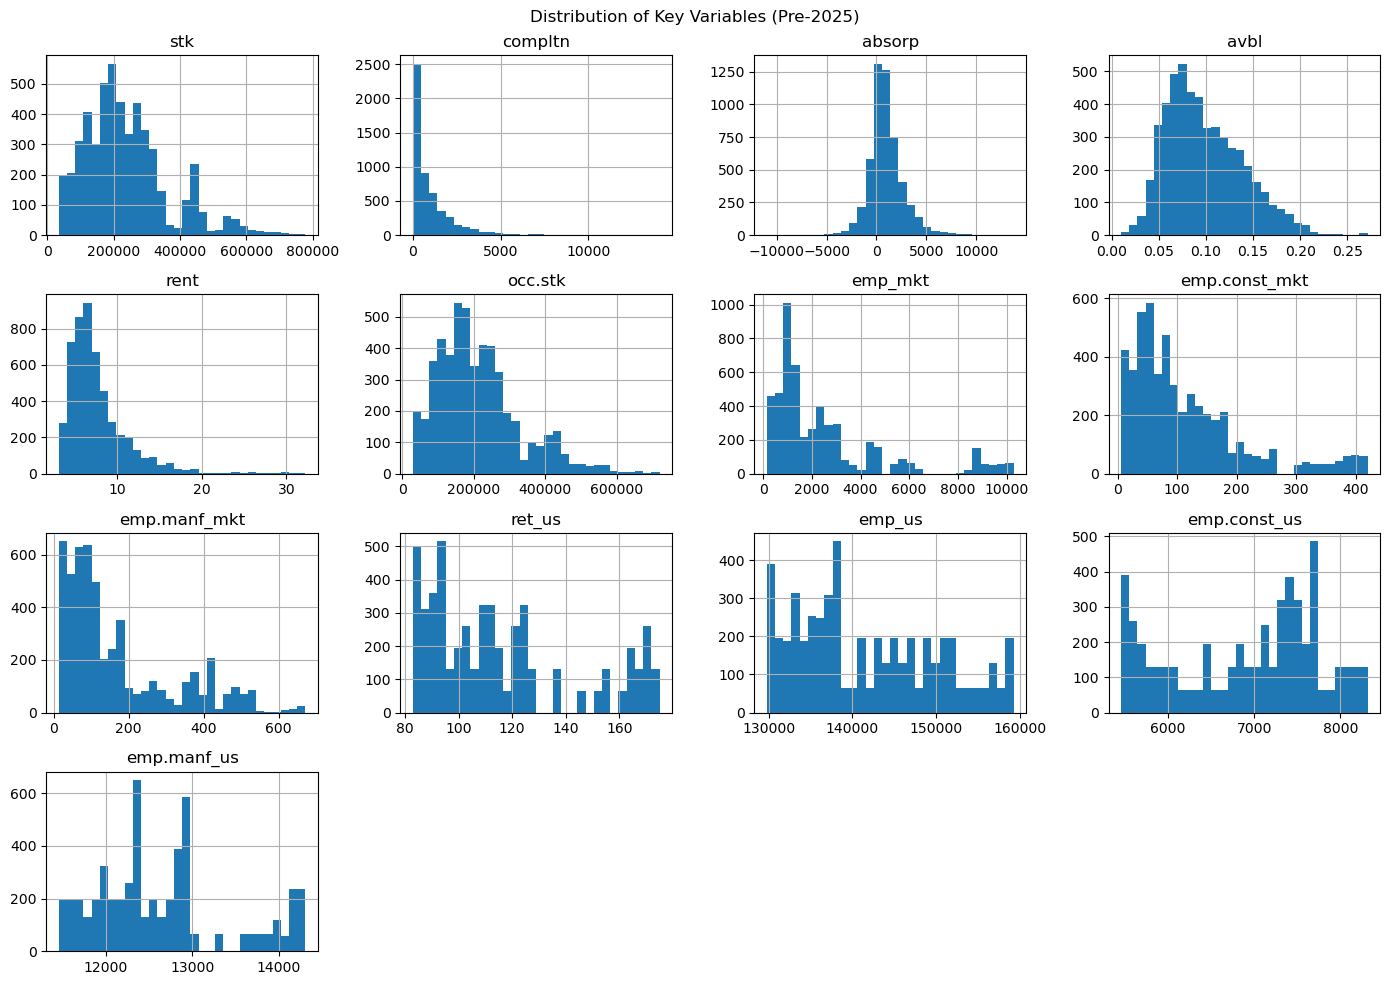

In [345]:
# Exploratory Data Analysis (EDA):
# I want to now find distributions in this pre-2025 data 

# Drop year and quarter to build out some histograms to correctly understand independent and dependent variables
cols_to_analyze = pre2025_df.drop(columns=['year', 'quarter']).select_dtypes(include='number').columns

pre2025_df[cols_to_analyze].hist(bins=30, figsize=(14, 10))
plt.suptitle("Distribution of Key Variables (Pre-2025)")
plt.tight_layout()
plt.show()


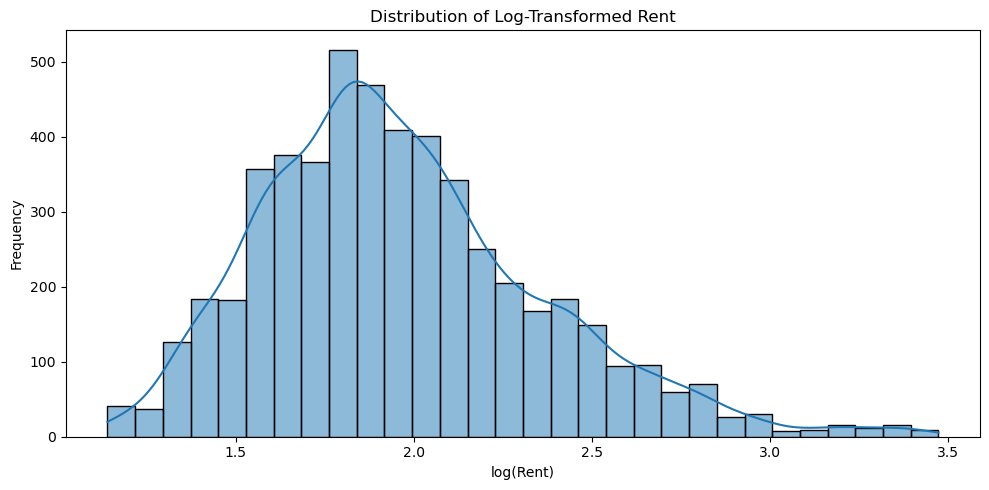

In [346]:
# Exploratory Data Analysis (EDA):
# Due to the right-skewness of the rent variable, I'll apply a log-transform. Logging compresses the high-rent values, 
# which reduces the influence of large outliers possibly from bigger regions. 

# Apply log transform

pre2025_df = hist_rent_data[hist_rent_data['year'] < 2025].copy()
pre2025_df['log_rent'] = np.log(pre2025_df['rent'])

# Plt
plt.figure(figsize=(10, 5))
sns.histplot(pre2025_df['log_rent'], bins=30, kde=True)
plt.title("Distribution of Log-Transformed Rent")
plt.xlabel("log(Rent)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Now, the distribution has become more symmetric.


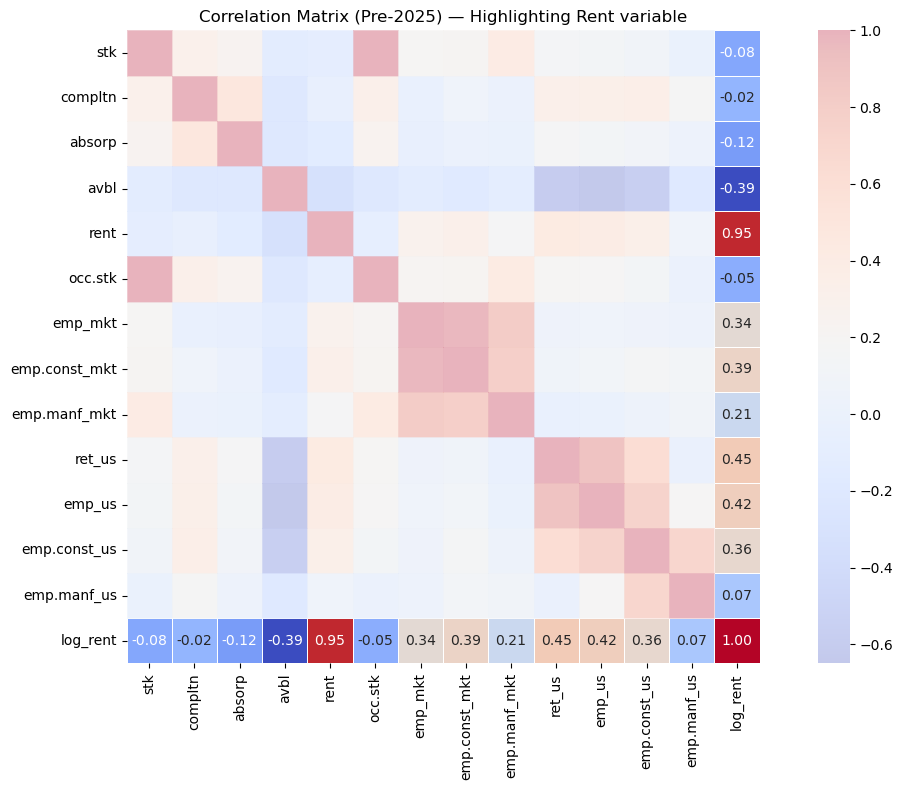

In [347]:
# Exploratory Data Analysis (EDA):
# I want to find out which of these independent variables have high correlations with each other
# and more specifically focus on which of these variables have any correlation with rent prices

cols_to_analyze_ = pre2025_df.drop(columns=['year', 'quarter']).select_dtypes(include='number').columns

corr_matrix = pre2025_df[cols_to_analyze_].corr()

# A mask to highlight rent
highlight_rent = np.zeros_like(corr_matrix, dtype=bool)
rent_idx = corr_matrix.columns.get_loc('log_rent')
highlight_rent[rent_idx, :] = True
highlight_rent[:, rent_idx] = True

# Draw the heatmap with highlighted rent correlations
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    mask=~highlight_rent,
    cbar=False,
    square=True
)

# Overlay full matrix for context with dimming
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    mask=highlight_rent,
    cbar=True,
    square=True,
    alpha=0.3  # dim everything else
)

plt.title("Correlation Matrix (Pre-2025) — Highlighting Rent variable")
plt.tight_layout()
plt.show()

In [348]:
# Exploratory Data Analysis (EDA):
# Interpretation of the correlation matrix:

# The variables which correlate most with rent prices are ret_us, emp_us, emp.const_us, emp.const_mkt
# This seems to suggest that regardless of local supply and demand in a particular area,
# Rent prices move with macro trends a lot more i.e. we can give precedent to a pooled OLS over a panel regression
# model with fixed effects (as a baseline) which would capture more of the metro by metro nuances

In [349]:
# Exploratory Data Analysis (EDA):
# Understanding/expecting high multi-collinearity of the independent variables that may cause
# unstable coefficient estimates and infate standard errors

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Testing Variance Inflation Factor (VIF for multi-collinearity)
features = ['ret_us', 'emp_us', 'emp.const_us', 'emp.const_mkt']
X = df_grouped[features].dropna()

# Compute VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
# Extremely high (Makes Sense) ... So these can be combined into a single variable for a simpler linear model. 

         feature          VIF
0         ret_us    48.318340
1         emp_us   185.002723
2   emp.const_us  4452.434344
3  emp.const_mkt  3025.601278


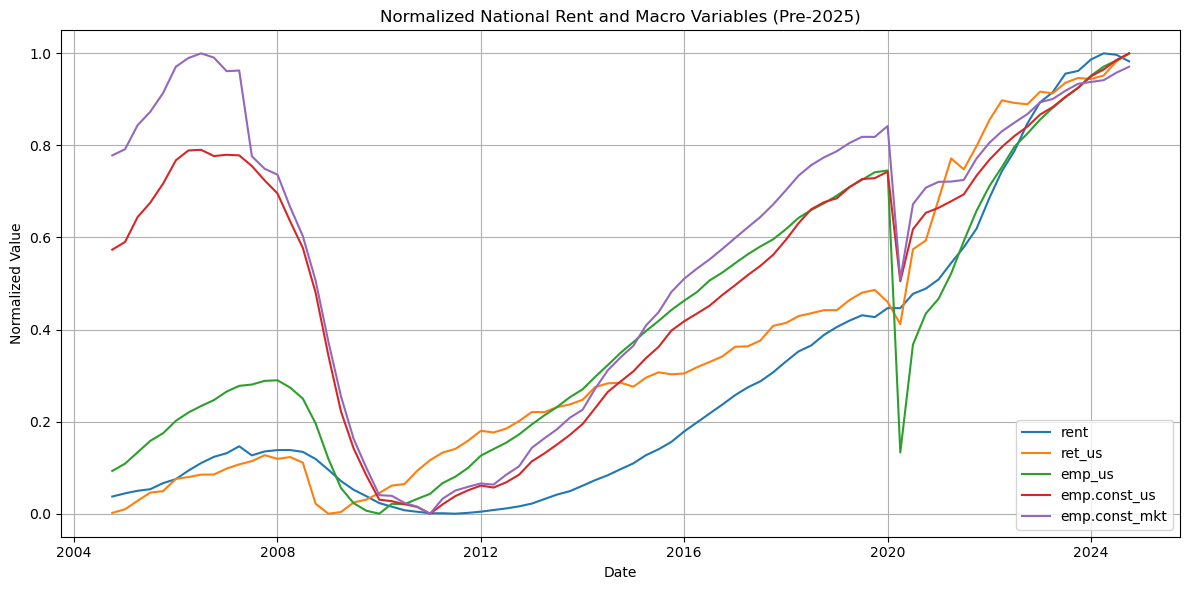

In [350]:
# Exploratory Data Analysis (EDA):
# Exploring national trendline (over time) for rent vs its more correlated variables to confirm hypothesis of a 
# more intensive macro variable relationship
# But the problem is that the variables are measured on different scales, so we will need to scale
# Here I choose to use a commonly used scaler: MinMaxScaler that transforms every variable to lie within the
# the range of [0,1] ---> this is better for visualization and interpretation of trends

# Mathematically: x' = (x-x_min)/(x_max-x_min)
# This allows us to visualize the variables we are concerned with without facing magnitude issues
# i.e. emp_us would dominate the y-axis and other variables would be almost invisible to interpretation. 

from sklearn.preprocessing import MinMaxScaler


# Group by year and quarter, then calculate national averages
df_grouped = pre2025_df.groupby(['year', 'quarter']).mean(numeric_only=True).reset_index()
df_grouped['date'] = pd.PeriodIndex(year=df_grouped['year'], quarter=df_grouped['quarter'], freq='Q').to_timestamp()

# Scale
vars_to_plot = ['rent', 'ret_us', 'emp_us', 'emp.const_us', 'emp.const_mkt']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_grouped[vars_to_plot])
scaled_df = pd.DataFrame(scaled_data, columns=vars_to_plot)
scaled_df['date'] = df_grouped['date']

# Plot
plt.figure(figsize=(12, 6))

for col in vars_to_plot:
    plt.plot(scaled_df['date'], scaled_df[col], label=col)

plt.title('Normalized National Rent and Macro Variables (Pre-2025)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [351]:
# Exploratory Data Analysis (EDA):
# If the macro data can be reduced into a single variable, then given the high amount of correlation and 
# possible multicollinearity, perhaps the local employment data can as well:

# Test for multicollinearity among local employment data

local_emp_features = ['emp_mkt', 'emp.const_mkt', 'emp.manf_mkt']
X_local_emp = df_grouped[local_emp_features].dropna()

# Compute VIF
vif_data_local_emp = pd.DataFrame()
vif_data_local_emp['feature'] = X_local_emp.columns
vif_data_local_emp['VIF'] = [variance_inflation_factor(X_local_emp.values, i) for i in range(X_local_emp.shape[1])]

print(vif_data_local_emp)
# Again super high, should be combined into a single feature as to not over inflate the explainable variance 


         feature         VIF
0        emp_mkt  157.903418
1  emp.const_mkt  148.620239
2   emp.manf_mkt   98.899021


In [352]:
# Data Pre-Processing:
# We know from the correlation table and the VIF analysis that the macro factors face multi-collinearity issues
# Additionally we know the same of the local_employment factors 
# To avoid issues of multi-collinearity, my plan is to use dimension reduction techniques, specifically,
# a Principal Component Analysis. The goal here is to build two components:
# 1) 1 or 2 Macro factor component 2) 1 or 2 local Employment component 
# Macro PCA 1 (Macro_index) explained 66.8% of the variability among the 4 variables
# I would like the components to explain more, so I've decided to find a second component 
# to capture the idiosyncratic movements in each macro variable (noise, timing, sector-specific variation, etc.)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Macro Component 
macro_vars = ['ret_us', 'emp_us', 'emp.const_us', 'emp.manf_us']
macro_data = pre2025_df[macro_vars]

macro_scaled = StandardScaler().fit_transform(macro_data)

# Macro PCA
pca_macro = PCA(n_components=2)
macro_components = pca_macro.fit_transform(macro_scaled)

# Add back to the df
pre2025_df.loc[macro_data.index, 'macro_PC1'] = macro_components[:, 0]
pre2025_df.loc[macro_data.index, 'macro_PC2'] = macro_components[:, 1]

# Variance explained by each
print("Explained variance ratios:")
for i, var in enumerate(pca_macro_2.explained_variance_ratio_):
    print(f"Macro_PC{i+1}: {var:.2%}")

# Comment: Okay this is more to my liking where over 96% of the variability between our 
# 4 macro variables are explained by the two components


Explained variance ratios:
Macro_PC1: 66.80%
Macro_PC2: 30.16%


In [353]:
# Data Pre-Processing:
# We will now continue the same exercise for the local employment component

local_vars = ['emp_mkt', 'emp.const_mkt', 'emp.manf_mkt']

local_data = pre2025_df[local_vars]
local_scaled = StandardScaler().fit_transform(local_data)

# PCA
pca_local = PCA(n_components=1)
local_emp_components = pca_local.fit_transform(local_scaled)

pre2025_df.loc[local_data.index, 'local_emp_components'] = local_index.ravel()

print(f"Local Index Variance Explained: {pca_local.explained_variance_ratio_[0]:.2%}")

# Since over 90% of the variance between our 3 local employment variables is explained by 1 component,
# There is no need for a second component

Local Index Variance Explained: 90.79%


I'm starting to build out what the forecasting model should be. For the sake of simplicity,
I start with a linear model

$$
\log(\text{Rent}_{it}) = 
\beta_1 \cdot \text{macro_PC1}_t + 
\beta_2 \cdot \text{macro_PC2}_t + 
\beta_3 \cdot \text{local_emp_index}_{it} + 
\beta_4 \cdot \text{stk}_{it} +
\beta_5 \cdot \text{compltn}_{it} +
\beta_6 \cdot \text{absorp}_{it} +
\beta_7 \cdot \text{avbl}_{it} +
\beta_8 \cdot \text{occ.stk}_{it} +
\epsilon_{it}
$$
However, I argue that this model is not enough. What we see from visualizing the rent time series is that there needs to be a component that captures the lagged effects of a macoeconomic shock. In 2008, during the financial crises, rent prices on average flatten out, but never really fall until 2011, bottoming out around 2011 Q4. Additionally, during the Covid crises, again stall (albeit for a lesser time), but continue to climb upward. So there needs to be a variable to capture this effect. 

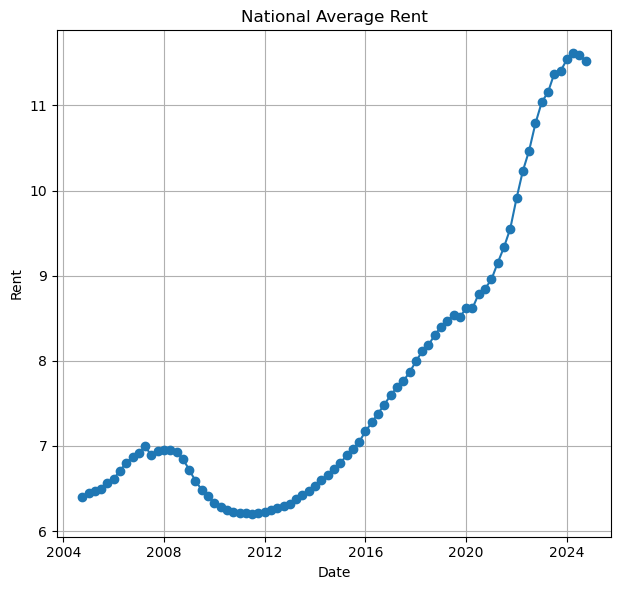

In [354]:
# Demonstration for modeling logic:
# This is just another visualization of Rent prices that supports the claim in the previous cell


# Group by time and take a national average
plot_df = pre2025_df.groupby(['year', 'quarter'])['rent'].mean().reset_index()
plot_df['date'] = pd.PeriodIndex(year=plot_df['year'], quarter=plot_df['quarter'], freq='Q').to_timestamp()

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(plot_df['date'], plot_df['rent'], marker='o')
plt.title("National Average Rent")
plt.xlabel("Date")
plt.ylabel("Rent")
plt.grid(True)


plt.tight_layout()
plt.show()

I propose experimenting with lagged dependent variables and some lagged macro components. So the model now looks like this:

$$
\log(\text{Rent}_{it}) = 
\beta_1 \cdot \text{macro_PC1}_{t-1} + 
\beta_2 \cdot \text{macro_PC2}_{t-1} +
\beta_3 \cdot \text{local_emp_index}_{it} + 
\beta_4 \cdot \text{stk}_{it} +
\beta_5 \cdot \text{compltn}_{it} +
\beta_6 \cdot \text{absorp}_{it} +
\beta_7 \cdot \text{avbl}_{it} +
\beta_8 \cdot \text{occ.stk}_{it} +
\epsilon_{it}
$$

I further argue the case that macro factors are lagged take time (t-1) to filter into local rental markets where as the local employment factors remains at (t) because renters respond quickly to job availability or layoffs in their city.

In [355]:
# Data Pre-Processing:
# Model (1) -- Pooled OLS

# pre2025_df.head()

columns_to_drop = [
    'local_emp_index',
    'ret_us', 'emp_us', 'emp.const_us', 'emp.manf_us',
    'emp_mkt', 'emp.const_mkt', 'emp.manf_mkt'
]

pooled_OLS_df = pre2025_df.drop(columns=[col for col in columns_to_drop if col in pre2025_df.columns])
pooled_OLS_df.head()

,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,year,quarter,log_rent,macro_PC1,macro_PC2,local_emp_components
0,Allentown,78202.0,538.0,1710.0,0.140,5.300719,67253.720,2004,4,1.667843,-0.454383,2.624273,-1.614524
1,Allentown,79282.0,1080.0,1664.0,0.131,5.398679,68896.058,2005,1,1.686154,-0.393861,2.569714,-1.614091
2,Allentown,79395.0,113.0,-1274.0,0.148,5.289835,67644.540,2005,2,1.665787,-0.217990,2.546826,-1.611721
3,Allentown,79527.0,132.0,1049.0,0.136,5.344257,68711.328,2005,3,1.676023,-0.094202,2.481134,-1.612060
4,Allentown,81005.0,1478.0,2378.0,0.122,5.398679,71122.390,2005,4,1.686154,0.019933,2.488702,-1.612207


In [356]:
# Data Pre-Processing:

# We need to now create a period column to start lagging the macro variables

from pandas import PeriodIndex

pooled_OLS_df['period'] = PeriodIndex(year=pooled_OLS_df['year'], quarter=pooled_OLS_df['quarter'], freq='Q').to_timestamp()

# Create Macro Lags

macro_df = pooled_OLS_df[['period', 'macro_PC1', 'macro_PC2']].drop_duplicates().sort_values('period')
macro_df['macro_PC1_lag1'] = macro_df['macro_PC1'].shift(1)
macro_df['macro_PC2_lag1'] = macro_df['macro_PC2'].shift(1)

# merge
pooled_OLS_df = pooled_OLS_df.merge(macro_df[['period', 'macro_PC1_lag1', 'macro_PC2_lag1']], on='period', how='left')


In [357]:
# Date Preprocessing:

# Need to drop NAs caused by lagging

pooled_df_Processed = pooled_OLS_df.dropna(subset=['macro_PC1_lag1', 'macro_PC2_lag1'])
pooled_df_Processed.head()

,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,year,quarter,log_rent,macro_PC1,macro_PC2,local_emp_components,period,macro_PC1_lag1,macro_PC2_lag1
1,Allentown,78202.0,538.0,1710.0,0.140,5.300719,67253.720,2004,4,1.667843,-0.454383,2.624273,-1.614524,2004-10-01,-0.454383,2.624273
2,Allentown,79282.0,1080.0,1664.0,0.131,5.398679,68896.058,2005,1,1.686154,-0.393861,2.569714,-1.614091,2005-01-01,-0.454383,2.624273
3,Allentown,79282.0,1080.0,1664.0,0.131,5.398679,68896.058,2005,1,1.686154,-0.393861,2.569714,-1.614091,2005-01-01,-0.393861,2.569714
4,Allentown,79395.0,113.0,-1274.0,0.148,5.289835,67644.540,2005,2,1.665787,-0.217990,2.546826,-1.611721,2005-04-01,-0.393861,2.569714
5,Allentown,79527.0,132.0,1049.0,0.136,5.344257,68711.328,2005,3,1.676023,-0.094202,2.481134,-1.612060,2005-07-01,-0.217990,2.546826


In [359]:
# Modelling
# Model (1) Pooled OLS

# In this section we code out a pooled OLS model which is quicker and helps us set a baseline, 
# but it ignores the panel structure
# of the data. This treats all rows as independent observations, even though some come 
# from the same city over time. We ignore fixed effects such as city effects.

import statsmodels.api as sm


# Establish matrix of independent vars
X = pooled_df_Processed[['macro_PC1_lag1', 'macro_PC2_lag1','local_emp_components', 'compltn', 'absorp', 'avbl','occ.stk','stk']]

# Dependent variable (Target variable)
y = pooled_df_Processed['log_rent']

# Constant/Intercept
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     415.6
Date:                Fri, 06 Jun 2025   Prob (F-statistic):               0.00
Time:                        04:01:53   Log-Likelihood:                -1246.6
No. Observations:                5260   AIC:                             2511.
Df Residuals:                    5251   BIC:                             2570.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.3313 

In [360]:
# Modelling:
# Sanity checks for multi-collinearity 

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

# It seems as though the occ.stk variable and the stk variable have huge problems with multi-collinearity 
# and are artificially inflating the R2 value
# And this makes sense since I assume stk is "Total Stock" and occ.stk is "Occupied Stock"
# Mathematically then occ.stk = stk x (1-available stock (or avbl))
# So we remove occ.stk as it is redundant and has a higher VIF and re-run to establish our baseline model


                feature         VIF
0                 const   34.124089
1        macro_PC1_lag1    1.954896
2        macro_PC2_lag1    1.077212
3  local_emp_components    1.144913
4               compltn    1.623266
5                absorp    1.407694
6                  avbl    4.857945
7               occ.stk  541.130307
8                   stk  524.699749


In [361]:
# Modelling:
# Re-running without occ.stk variable due to redundancy and huge VIF

# Establish matrix of independent vars
X_no_occstk = pooled_df_Processed[['macro_PC1_lag1', 'macro_PC2_lag1','local_emp_components', 'compltn', 'absorp', 'avbl','stk']]

# Dependent variable (Target variable)
y = pooled_df_Processed['log_rent']

# Constant/Intercept
X_no_occstk = sm.add_constant(X_no_occstk)

model = sm.OLS(y, X_no_occstk).fit()
print(model.summary())

# Recheck VIF

vif_df_2 = pd.DataFrame()
vif_df_2["feature"] = X_no_occstk.columns
vif_df_2["VIF"] = [variance_inflation_factor(X_no_occstk.values, i) for i in range(X_no_occstk.shape[1])]
print(vif_df_2)


                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     474.3
Date:                Fri, 06 Jun 2025   Prob (F-statistic):               0.00
Time:                        04:02:20   Log-Likelihood:                -1248.2
No. Observations:                5260   AIC:                             2512.
Df Residuals:                    5252   BIC:                             2565.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.2988 

This is our cleanest, most robust model yet as there are no multicollinearity issues. Our R^2 value is 0.387 which says that approximately 39% of the variability in rent prices can be explained by the independent variables in our pooled regression model. This is not a high R^2 value but it helps set a baseline. We can interpret some of the coefficients now. macro_PC1_lag1 has a positive coefficient of 0.0917 implying that better macroeconomic factors through the country leads to higher rent. macro_PC2_lag1 has a negative coefficient of -0.0563 which implies a sort of macro-drag, lowering rent prices. This could mean when construction or manufacturing in the country weaken, rent prices go down. Our Local_emp_component is positive meaning local job growth implies higher rent. Newer completions put downward rent pressure. Absorption is negative implying oversupply of rentable units leading to a negative impact on price. Higher availability has the largest negative effect on rent price. Finally, the stk variable is negative, implying higher total stock in any metropolitan area means lower rents. I imagine this as having lots of competing units and higher supply than demand pushing rent prices lower.  

In [362]:
# Application of forecasts to individual metro markets:
# As a sanity check, let us apply the model we just built to forecast
# quarterly rent prices per metro and see if they are believable 

# We are given forecasts already for 2025-2028 macro factors as well as 
# local employment factors (keep in mind, we used a PCA to build components)
# to address the multicollinearity issue. So we need to build a PCs from these.
# Using the exact same scaler_macro and pca_macro we fit on historical data

# establish a forecast_df from the original data
# This proves to be a problem later on as we have split the data set which results in lag issues of NaN
future_metros_list = hist_rent_data[hist_rent_data['year'] >= 2025]['ind_mkt'].unique()

macro_lag_base = hist_rent_data.query("year == 2024 and quarter == 4 and ind_mkt in @future_metros_list").copy()


forecast_df = hist_rent_data[hist_rent_data['year'] >= 2025].copy()
macro_full = pd.concat([macro_lag_base, forecast_df], axis=0).reset_index(drop=True)

macro_full['period'] = pd.PeriodIndex(
    year=macro_full['year'], quarter=macro_full['quarter'], freq='Q'
).to_timestamp()

# Reset index 
macro_full = macro_full.sort_values(['ind_mkt', 'period']).reset_index(drop=True)


# Macro vars re-established (Not needed)
macro_vars = ['ret_us', 'emp_us', 'emp.const_us', 'emp.manf_us']

# Re-fit the scaler
macro_data = pre2025_df[macro_vars]
scaler_macro = StandardScaler().fit(macro_data)
macro_scaled = scaler_macro.transform(macro_data)

pca_macro = PCA(n_components=2).fit(macro_scaled)


# Application of the previous scaler to new 2025 data
macro_scaled_forecast = scaler_macro.transform(macro_full[macro_vars])
macro_pcs_forecast = pca_macro.transform(macro_scaled_forecast)

macro_full['macro_PC1_forecasted'] = macro_pcs_forecast[:, 0]
macro_full['macro_PC2_forecasted'] = macro_pcs_forecast[:, 1]


# Recall that we lagged this (t-1) ... so same step here

macro_full = macro_full.sort_values(['ind_mkt', 'period'])
macro_full['macro_PC1_fcast_lag1'] = macro_full.groupby('ind_mkt')['macro_PC1_forecasted'].shift(1)
macro_full['macro_PC2_fcast_lag1'] = macro_full.groupby('ind_mkt')['macro_PC2_forecasted'].shift(1)



# Out of sample, drop the 2024 Q4 row after lagging

OOS_full = macro_full[macro_full['year'] >= 2025].copy()
OOS_full.head()

,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,emp_mkt,emp.const_mkt,emp.manf_mkt,...,emp_us,emp.const_us,emp.manf_us,year,quarter,period,macro_PC1_forecasted,macro_PC2_forecasted,macro_PC1_fcast_lag1,macro_PC2_fcast_lag1
1,Allentown,150580.900000,423.300000,492.028668,0.079752,NaN,138571.763093,403.5257,13.5488,41.6794,...,159685.0,8352.787,12982.66,2025,1,2025-01-01,3.441520,-0.790725,3.346398,-0.785410
2,Allentown,151051.800000,470.900000,215.816417,0.081192,NaN,138787.579510,404.4199,13.5591,41.7046,...,160091.0,8383.617,13008.97,2025,2,2025-04-01,3.534061,-0.798365,3.441520,-0.790725
3,Allentown,151051.800000,0.000000,513.586838,0.077792,NaN,139301.166348,405.1458,13.5643,41.7191,...,160440.0,8411.824,13028.84,2025,3,2025-07-01,3.621077,-0.813832,3.534061,-0.798365
4,Allentown,151285.393310,233.593310,351.275694,0.076894,NaN,139652.442043,405.8428,13.5754,41.7305,...,160782.0,8439.954,13047.83,2025,4,2025-10-01,3.706060,-0.828919,3.621077,-0.813832
5,Allentown,151878.031689,592.638379,282.909681,0.078633,NaN,139935.351724,406.3973,13.5841,41.7404,...,161025.8,8465.385,13059.85,2026,1,2026-01-01,3.777328,-0.846317,3.706060,-0.828919


In [363]:
# Sanity check
OOS_full.query("ind_mkt == 'WestPalmBeach'").sort_values('period').head(2)


,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,emp_mkt,emp.const_mkt,emp.manf_mkt,...,emp_us,emp.const_us,emp.manf_us,year,quarter,period,macro_PC1_forecasted,macro_PC2_forecasted,macro_PC1_fcast_lag1,macro_PC2_fcast_lag1
1089,WestPalmBeach,61136.582827,127.632827,385.467946,0.075527,NaN,56519.116538,3007.766,165.3808,100.5198,...,159685.0,8352.787,12982.66,2025,1,2025-01-01,3.441520,-0.790725,3.346398,-0.785410
1090,WestPalmBeach,61518.079170,381.496343,509.155516,0.072984,NaN,57028.272054,3016.459,166.1493,100.7942,...,160091.0,8383.617,13008.97,2025,2,2025-04-01,3.534061,-0.798365,3.441520,-0.790725


In [364]:
# Application:
# Creating the forecasted local emp PCA as per model

# fit a scaler and PCA on pre-2025 data
scaler_local = StandardScaler().fit(pre2025_df[local_vars])
pca_local = PCA(n_components=1).fit(scaler_local.transform(pre2025_df[local_vars]))

# Transform the post 2025 data

local_scaled_forecast = scaler_local.transform(OOS_full[local_vars])
OOS_full['local_emp_components'] = pca_local.transform(local_scaled_forecast)

OOS_full.head()

,ind_mkt,stk,compltn,absorp,avbl,rent,occ.stk,emp_mkt,emp.const_mkt,emp.manf_mkt,...,emp.const_us,emp.manf_us,year,quarter,period,macro_PC1_forecasted,macro_PC2_forecasted,macro_PC1_fcast_lag1,macro_PC2_fcast_lag1,local_emp_components
1,Allentown,150580.900000,423.300000,492.028668,0.079752,NaN,138571.763093,403.5257,13.5488,41.6794,...,8352.787,12982.66,2025,1,2025-01-01,3.441520,-0.790725,3.346398,-0.785410,-1.610653
2,Allentown,151051.800000,470.900000,215.816417,0.081192,NaN,138787.579510,404.4199,13.5591,41.7046,...,8383.617,13008.97,2025,2,2025-04-01,3.534061,-0.798365,3.441520,-0.790725,-1.610275
3,Allentown,151051.800000,0.000000,513.586838,0.077792,NaN,139301.166348,405.1458,13.5643,41.7191,...,8411.824,13028.84,2025,3,2025-07-01,3.621077,-0.813832,3.534061,-0.798365,-1.610010
4,Allentown,151285.393310,233.593310,351.275694,0.076894,NaN,139652.442043,405.8428,13.5754,41.7305,...,8439.954,13047.83,2025,4,2025-10-01,3.706060,-0.828919,3.621077,-0.813832,-1.609727
5,Allentown,151878.031689,592.638379,282.909681,0.078633,NaN,139935.351724,406.3973,13.5841,41.7404,...,8465.385,13059.85,2026,1,2026-01-01,3.777328,-0.846317,3.706060,-0.828919,-1.609500


In [365]:
# Application:
# Lets generate/forecast some rent prices from 2025-2028 

predictors = [
    'macro_PC1_fcast_lag1', 'macro_PC2_fcast_lag1',
    'local_emp_components', 'compltn', 'absorp', 'avbl', 'stk'
]

# This is the X df of independent variables from the OOS
forecast_ready = OOS_full.dropna(subset=predictors).copy()

# Adding constant and running prediction
X_fcast = sm.add_constant(forecast_ready[predictors])
forecast_ready['log_rent_pred'] = model.predict(X_fcast)

# Since we did a log transform on the rent, we need to convert it back to dollars

forecast_ready['rent_pred'] = np.exp(forecast_ready['log_rent_pred'])
rent_forecast_output = forecast_ready[['ind_mkt', 'year', 'quarter', 'rent_pred']].copy()
rent_forecast_output = rent_forecast_output.sort_values(['ind_mkt', 'year', 'quarter']).reset_index(drop=True)

print(rent_forecast_output)

            ind_mkt  year  quarter  rent_pred
0         Allentown  2025        1   9.946868
1         Allentown  2025        2  10.075592
2         Allentown  2025        3  10.240950
3         Allentown  2025        4  10.335043
4         Allentown  2026        1  10.334969
...             ...   ...      ...        ...
1035  WestPalmBeach  2027        4  13.721226
1036  WestPalmBeach  2028        1  13.816718
1037  WestPalmBeach  2028        2  13.909840
1038  WestPalmBeach  2028        3  13.999929
1039  WestPalmBeach  2028        4  14.088690

[1040 rows x 4 columns]


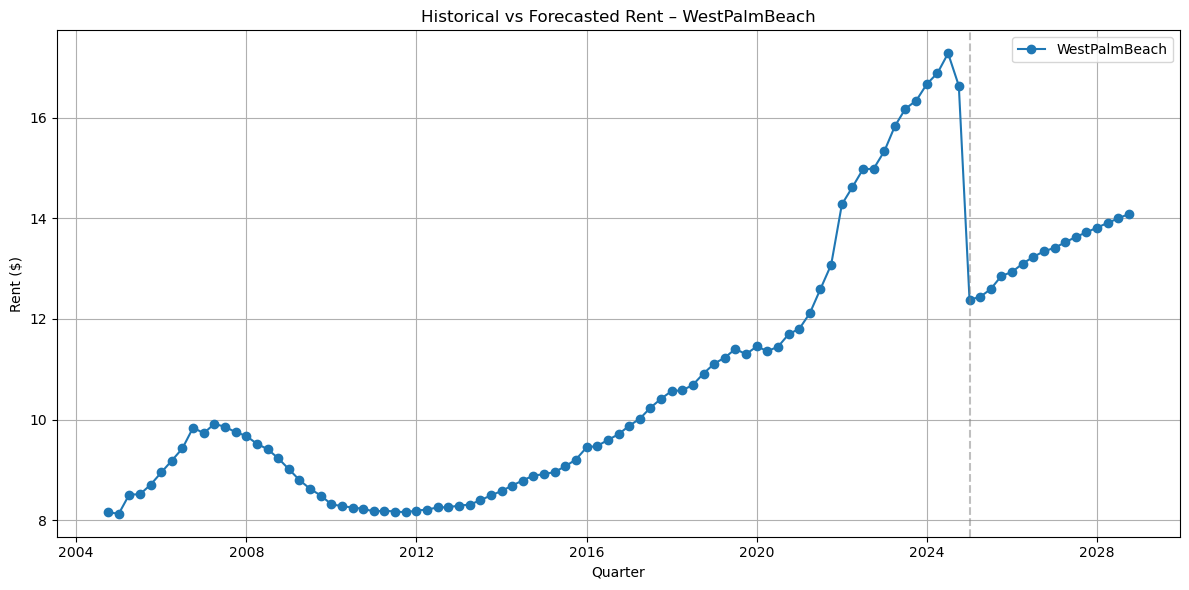

In [382]:
# Sanity check:
# So we have predicted values out for the future. We need to do a sanity check and make sure our predictions
# roughly align with historical trends.

# We are going to first try to do this visually 
# This code is a bit repetitive but, it will help us just sample by metro

# Here, recall historical rent (pre-2025 only)
historical_rent = hist_rent_data[hist_rent_data['year'] < 2025].copy()
historical_rent['period'] = pd.PeriodIndex(
    year=historical_rent['year'], quarter=historical_rent['quarter'], freq='Q'
).to_timestamp()

historical_rent['type'] = 'historical'
historical_rent = historical_rent[['ind_mkt', 'period', 'rent']]
historical_rent.rename(columns={'rent': 'rent_value'}, inplace=True)

# Lets gather our forecasted data 

rent_forecast_output['period'] = pd.PeriodIndex(
    year=rent_forecast_output['year'], quarter=rent_forecast_output['quarter'], freq='Q'
).to_timestamp()

rent_forecast_output['type'] = 'forecast'
rent_forecast_output.rename(columns={'rent_pred': 'rent_value'}, inplace=True)

# Combine
combined_rent = pd.concat([historical_rent, rent_forecast_output[['ind_mkt', 'period', 'rent_value', 'type']]])

# Filter one metro for quick sanity check
metro_sample = 'WestPalmBeach'  # or any metro 

plt.figure(figsize=(12, 6))
for mkt in [metro_sample]:
    df_plot = combined_rent[combined_rent['ind_mkt'] == mkt]
    plt.plot(df_plot['period'], df_plot['rent_value'], label=f"{mkt}", linestyle='-', marker='o')
    plt.axvline(pd.Timestamp('2025-01-01'), color='gray', linestyle='--', alpha=0.5)

plt.title(f"Historical vs Forecasted Rent – {metro_sample}")
plt.ylabel("Rent ($)")
plt.xlabel("Quarter")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This seems to be a concerning jump and could mean that our model may not be functioning well or there is a data issue. But first we are going to proceed to see if any of the forecasted independent variables also have jumps. Obviously there exist more metro related (micro non-linear dependcies).  

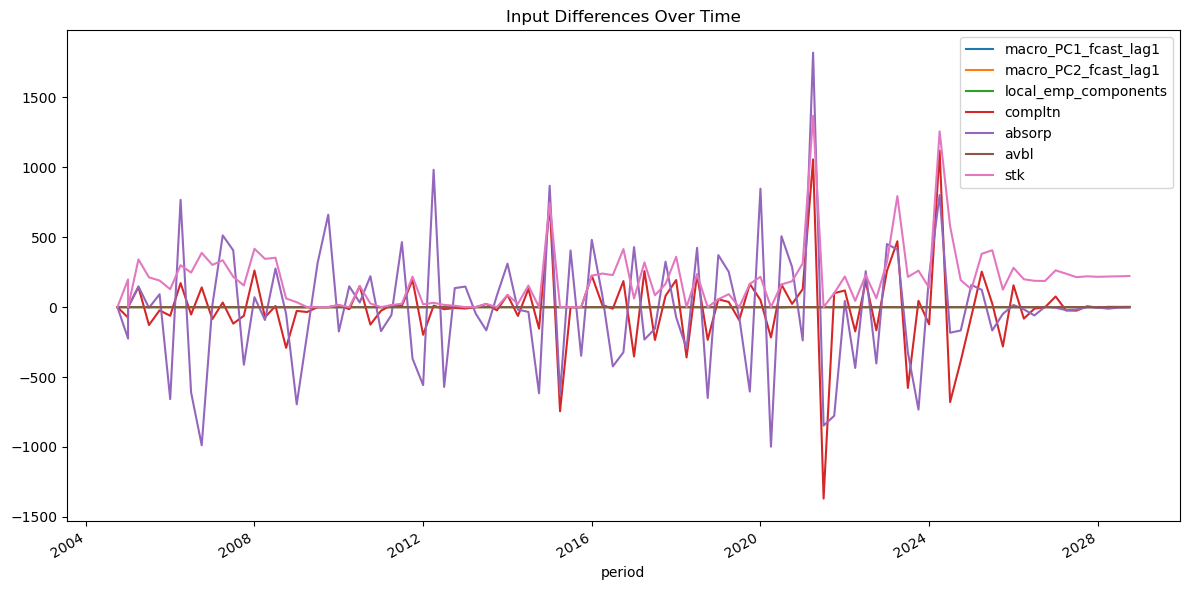

In [380]:
# Sanity check:
# Lets see if any of the other variables are causing this spike

# Standardize column names for concatenation
pooled_df_renamed = pooled_df.rename(columns={
    'macro_PC1_lag1': 'macro_PC1_fcast_lag1',
    'macro_PC2_lag1': 'macro_PC2_fcast_lag1',
    'local__emp_components': 'local_emp_components'
})

# List of variables to compare
common_cols = [
    'macro_PC1_fcast_lag1', 'macro_PC2_fcast_lag1',
    'local_emp_components', 'compltn', 'absorp', 'avbl', 'stk'
]

# Subset the data for WestPalmBeach
hist_subset = pooled_df_renamed[pooled_df_renamed['ind_mkt'] == 'WestPalmBeach']
forecast_subset = OOS_full[OOS_full['ind_mkt'] == 'WestPalmBeach']

# Keep only relevant columns
hist_subset = hist_subset[['period'] + common_cols + ['log_rent']]
forecast_subset = forecast_subset[['period'] + common_cols]

# Concatenate and sort
combined = pd.concat([hist_subset, forecast_subset], axis=0).sort_values('period')

# Plot the differences
combined.set_index('period')[common_cols].diff().plot(
    title="Input Differences Over Time", figsize=(12, 6)
)

plt.tight_layout()
plt.show()


Here we see why there is a jump in the forecasted rent price. We see compltn, absorp and stk experience a large jump at the start of 2025. We know from our model that absorp, completion and stock all have a negative impact on the rent price. Thus, when fed large jumps in inputs — our model returns a large predicted rent change. At this point we could smooth the jumps or manually winsorize the input change or switch to a more time-series forecasting model like an ARIMAX. For now, I'll just go on to my yearly rent growth.

In [369]:
# Forecast annual U.S. rent growth (YoY, Q4 to Q4) 
# The task at hand was to forecast the YoY growth by quarter, lets see how our Pooled OLS
# model does.

# Get historical data for Q4 2024

q4_2024 = pre2025_df[pre2025_df['quarter'] == 4]
q4_2024 = q4_2024[['ind_mkt', 'year', 'quarter', 'rent']].copy()
q4_2024['rent_pred'] = q4_2024['rent']
#q4_2024['rent_value'] = np.exp(q4_2024['log_rent'])


# Filter out the Q4 observationss
q4_forecast = rent_forecast_output[rent_forecast_output['quarter'] == 4][['ind_mkt', 'year', 'quarter', 'rent_pred']]
q4_combined = pd.concat([q4_2024[['ind_mkt', 'year', 'quarter', 'rent_pred']], q4_forecast], ignore_index=True)

# Find the averages
national_q4_avg = q4_combined.groupby('year')['rent_pred'].mean().sort_index()
rent_growth = national_q4_avg.pct_change().dropna() * 100

print("Forecasted National Annual Rent Growth (Q4 over Q4):")
for year, growth in rent_growth.round(2).items():
    print(f"{year}: {growth}%")


Forecasted National Annual Rent Growth (Q4 over Q4):
2005: 2.46%
2006: 4.7%
2007: 0.93%
2008: -1.28%
2009: -6.39%
2010: -2.85%
2011: -0.21%
2012: 1.23%
2013: 2.84%
2014: 3.99%
2015: 4.77%
2016: 6.22%
2017: 5.06%
2018: 5.59%
2019: 2.51%
2020: 3.93%
2021: 7.97%
2022: 12.93%
2023: 5.72%
2024: 0.98%
2025: -6.0%
2026: 2.73%
2027: 2.19%
2028: 2.37%


We see the 2020–2022 surge (especially 2021 & 2022) aligns with known post-COVID rent spikes. Then we see the dip (-6.0%) in 2025 — could reflect supply glut which we also saw in the West Palm Beach (negative dip), Allentown (negative dip) and ChicagoInner (positive swing) cases. Finally, for the 2026 to 2028 years, we see steady normalization in the 2–3% range, indicating modest rent increase. So while the analysis may not have captured every non-linearity and auto-regressive dependencies, the results are believable and more importantly very easy to explain i.e. high interpretability. 

I did a quick google search to see how far off from the actual 2024 increase. According to an article by the National Mortgage Professional, single-family rental (which are the second largest rental block) rates grew by about 0.8%. So without knowing exactly what kind of properties this dataset is referring to, it's hard to have a definitive sense but intuitively it seems as though this analysis captured trends well and forecasted within a forgivable range 


Source: https://nationalmortgageprofessional.com/news/rent-growth-sees-smallest-increase-years

For future analysis, I would like to build a model that captures all unobserved, time-invariant factors associated with each metro. For this, I believe a panel data OLS with Fixed Effects -- holding steady our Components and lags. I suspect that the unobserved characteristics of each entity (like metro areas) might bias my OLS estimates further. Our Model (1), the pooled OLS, assumes all metros are identical and share the same intercept. Though I believe we got decent results with our pooled OLS, I fear we miss the granularity that a panel OLS could provide, metro by metro. However, from my experience, I know that fixed effect models in general lose explanatory power because they absorb all of the time-invariant difference by including a dummy variable. By design panel OLS cannot estimate the effect of any variable that is constant within a city over time, because it's perfectly collinear with the fixed effect.  